# Introduction

This notebook works through chapter 5 of the fastai book, which is a "deeper dive" into image classification. We will take a first pass at following the book linearly, followed by a second pass developing some working code in the form of a unified script or at least a `.org` file.

One aside: this represents my first use of the `juno` iPad app. The notebook server is running on my laptop, but I am working from my ipad. I am also testing a workflow wherein I am getting everything "working" on my laptop, and then pulling my git repo from a much more powerful remote machine with a GPU as needed.

In [10]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

# Data Setup
The first thing we need to do is figure out how the data are laid out and to set up our dataloaders accordingly. We start by investigating the structure of our downloaded data.

In [11]:
path.ls()

(#2) [Path('/home/djliden91/.fastai/data/oxford-iiit-pet/annotations'),Path('/home/djliden91/.fastai/data/oxford-iiit-pet/images')]

We're going to ignore the "annotations" directory for now as it contains information on *where* the pets are while we're interested in *what* they are. So we will explore the `images` folder.

In [12]:
(path/"images").ls()

(#7393) [Path('/home/djliden91/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_96.jpg'),Path('/home/djliden91/.fastai/data/oxford-iiit-pet/images/Siamese_218.jpg'),Path('/home/djliden91/.fastai/data/oxford-iiit-pet/images/British_Shorthair_82.jpg'),Path('/home/djliden91/.fastai/data/oxford-iiit-pet/images/pug_115.jpg'),Path('/home/djliden91/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_97.jpg'),Path('/home/djliden91/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_42.jpg'),Path('/home/djliden91/.fastai/data/oxford-iiit-pet/images/great_pyrenees_123.jpg'),Path('/home/djliden91/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_185.jpg'),Path('/home/djliden91/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_103.jpg'),Path('/home/djliden91/.fastai/data/oxford-iiit-pet/images/german_shorthaired_184.jpg')...]

Now we need to figure out how to extract the breed names from the filenames. We have breed names (which may be more than one word, separated by underscores), followed by an underscore and a number (at least according to what we can see here so far).

We will use regular expressions to do this. The book notes that the name for regular expressions comes from Chomsky and that they're based, in some way, on his "Syntactic Structures."

In [13]:
fname = (path/"images").ls()[0]
re.findall(r'(.+)_\d+.jpg$', fname.name)

['english_cocker_spaniel']

OK, that worked for our single example. I'm unsure what the `r'` does, and the `(.+)` seems to get all characters before we hit an underscore and a `digit.jpg`, but I'm not entirely certain.
- `d` matches anty decimal digit.
- `+` matches the preceding argument one or more times. so `\d+` is matching *one or more digits*.
- `.` represents *any* single character, so `.+` represents one or more characters.
- parentheses identify a subexpression. When the parentheses are excluded, we also capture the number, which we don't want. It seems that, in this instance, the parentheses tell us *what* to capture, though I need to read up on how they do so.
- `r'` indicates a *raw string*. Regex makes liberal use of backslashes, and we don't want Python to attempt to interepret the backslash in any way before passing it to the regex function.

Now we will use our regular expression to label the full dataset.   

In [14]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items=get_image_files,
                splitter=RandomSplitter(seed=27),
                get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                item_tfms=Resize(460),
                batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

Some important transforms we have not worked with before:
- `item_tfms=Resize(460)` and `batch_tfms=aug_transforms(size=224, min_scale=0.75)`

Why are we taking this approach? If we perform the transformations and augmentations after scaling down to the training size, we risk significantly distorting our training samples, introducing empty areas, etc. So instead we pre-size all of our samples to a larger size, and then do all of the final augmentations and a resize in one step using (if available) the GPU.

In the `item_tfms` step, the image is cropped to the full width or height (at random). Note that the crop area in the validation set is *always* the center square of the image. The `batch_ftms` handles random cropping and other augmentations and the final resizing. Note that including `min_scale` in `batch_tfms` ensures `RandomResizedCrop` is added to `aug_transforms` automatically.   

## Debugging a DataBlock
Using the `show_batch()` method. Q: how does this work when you're *not* in a notebook environment?

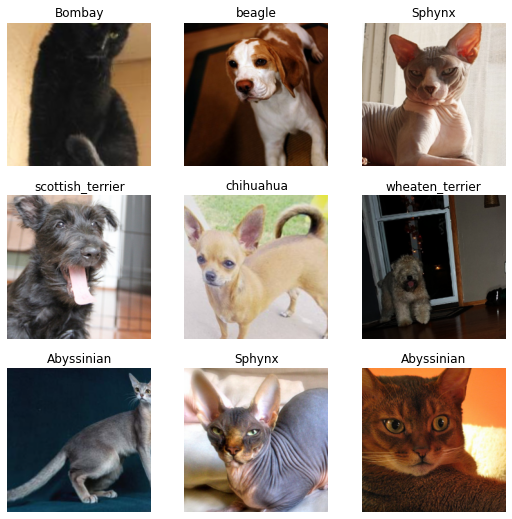

In [18]:
dls.show_batch(nrows=3, ncols=3)

We can also use the `summary` method to investigate our `DataBlock`

In [19]:
pets.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/djliden91/.fastai/data/oxford-iiit-pet/images/newfoundland_95.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=333x500
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /home/djliden91/.fastai/data/oxford-iiit-pet/images/newfoundland_95.jpg
    applying partial gives
      newfoundland
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(27)

Final sample: (PILImage mode=RGB size=333x500, TensorCategory(27))


Setting up after_item: Pipeline: Resize -- {'size': (460, 460), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_ba

If we, for instance, forgot to resize our images (such that batch transforms were not possible), we would see an error at this point using the `summary` method.

## Training an initial model

JH recommends training an initial model sooner rather than later to catch any extremely obvious issues and to establish a baseline prior to any tweaking. So we're going to apply a CNN learner without messing with hyperparameters etc.

Trying to run this on my laptop makes it immediately clear that it will be much, much faster running this on my gcloud machine.

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)